In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('feature_enhanced.csv')

# Separate features and target
X = df.drop('taxvaluedollarcnt', axis=1)
y = df['taxvaluedollarcnt']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", X_train.shape, "Test set size:", X_test.shape)

# Baseline MAE (mean predictor)
train_mean_value = y_train.mean()
baseline_pred_train = np.full(len(y_train), train_mean_value)
baseline_pred_test = np.full(len(y_test), train_mean_value)
baseline_mae_train = mean_absolute_error(y_train, baseline_pred_train)
baseline_mae_test = mean_absolute_error(y_test, baseline_pred_test)

# Evaluation metric function
def compute_metrics(y_true, y_pred, baseline_mae):
    mae_val = mean_absolute_error(y_true, y_pred)
    mse_val = mean_squared_error(y_true, y_pred)
    rmse_val = np.sqrt(mse_val)
    mask = y_true != 0
    mape_val = np.mean(np.abs((y_pred[mask] - y_true[mask]) / y_true[mask])) * 100
    y_pred_clip = np.where(y_pred < 0, 0, y_pred)
    y_true_clip = np.where(y_true < 0, 0, y_true)
    msle_val = mean_squared_error(np.log1p(y_true_clip), np.log1p(y_pred_clip))
    rmsle_val = np.sqrt(msle_val)
    r2_val = r2_score(y_true, y_pred)
    mase_val = mae_val / baseline_mae if baseline_mae != 0 else np.nan
    return r2_val, mae_val, rmse_val, mape_val, mase_val, rmsle_val


Train set size: (1373352, 32) Test set size: (343339, 32)


In [3]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2, cv_mae, cv_rmse, cv_mape, cv_mase, cv_rmsle = [], [], [], [], [], []

# 5-fold Cross Validation
for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    model = LinearRegression()
    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)
    r2, mae, rmse, mape, mase, rmsle = compute_metrics(y_val, y_val_pred, baseline_mae_train)
    cv_r2.append(r2)
    cv_mae.append(mae)
    cv_rmse.append(rmse)
    cv_mape.append(mape)
    cv_mase.append(mase)
    cv_rmsle.append(rmsle)

#results
cv_results = {
    "R2":    np.mean(cv_r2),
    "MAE":   np.mean(cv_mae),
    "RMSE":  np.mean(cv_rmse),
    "MAPE":  np.mean(cv_mape),
    "MASE":  np.mean(cv_mase),
    "RMSLE": np.mean(cv_rmsle)
}

lin_reg_final = LinearRegression()
lin_reg_final.fit(X_train, y_train)

y_test_pred = lin_reg_final.predict(X_test)
r2_te, mae_te, rmse_te, mape_te, mase_te, rmsle_te = compute_metrics(
    y_test, y_test_pred, baseline_mae_test
)

test_results = {
    "R2":    r2_te,
    "MAE":   mae_te,
    "RMSE":  rmse_te,
    "MAPE":  mape_te,
    "MASE":  mase_te,
    "RMSLE": rmsle_te
}

print("\n===== Linear Regression CV Results =====")
for k, v in cv_results.items():
    print(f"{k}: {v:.4f}")

print("\n===== Linear Regression Test Results =====")
for k, v in test_results.items():
    print(f"{k}: {v:.4f}")



===== Linear Regression CV Results =====
R2: 0.5406
MAE: 169344.7594
RMSE: 289351.4199
MAPE: 78.5569
MASE: 0.6994
RMSLE: 1.1301

===== Linear Regression Test Results =====
R2: 0.5428
MAE: 169242.7143
RMSE: 289098.5775
MAPE: 78.3467
MASE: 0.6968
RMSLE: 1.1231


In [4]:
#RF parameters
rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    min_samples_leaf=50,
    max_samples=0.5,
    max_features=8,
    n_jobs=-1,
    random_state=42
)

#5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = []
cv_mae = []
cv_rmse = []
cv_mape = []
cv_mase = []
cv_rmsle = []

for tr_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    rf_reg.fit(X_tr, y_tr)
    y_val_pred = rf_reg.predict(X_val)
    r2, mae, rmse, mape, mase, rmsle = compute_metrics(y_val, y_val_pred, baseline_mae_train)
    cv_r2.append(r2)
    cv_mae.append(mae)
    cv_rmse.append(rmse)
    cv_mape.append(mape)
    cv_mase.append(mase)
    cv_rmsle.append(rmsle)

cv_results = {
    "R2":   np.mean(cv_r2),
    "MAE":  np.mean(cv_mae),
    "RMSE": np.mean(cv_rmse),
    "MAPE": np.mean(cv_mape),
    "MASE": np.mean(cv_mase),
    "RMSLE": np.mean(cv_rmsle)
}

rf_reg.fit(X_train, y_train)
y_test_pred = rf_reg.predict(X_test)

test_r2, test_mae, test_rmse, test_mape, test_mase, test_rmsle = compute_metrics(y_test, y_test_pred, baseline_mae_test)

test_results = {
    "R2":   test_r2,
    "MAE":  test_mae,
    "RMSE": test_rmse,
    "MAPE": test_mape,
    "MASE": test_mase,
    "RMSLE": test_rmsle
}

print("\n===== CV Results =====")
for k, v in cv_results.items():
    print(f"{k}: {v:.4f}")

print("\n===== Test Results =====")
for k, v in test_results.items():
    print(f"{k}: {v:.4f}")


===== CV Results =====
R2: 0.6035
MAE: 153305.2138
RMSE: 268816.5477
MAPE: 73.4974
MASE: 0.6331
RMSLE: 0.6462

===== Test Results =====
R2: 0.6077
MAE: 153001.8126
RMSE: 267785.3347
MAPE: 73.1570
MASE: 0.6299
RMSLE: 0.6445


In [5]:
#XGBoost parameters
xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.10,
    min_child_weight=250,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_lambda=10,
    reg_alpha=0.5,
    tree_method='hist',
    n_jobs=4,
    random_state=42
)

#5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2, cv_mae, cv_rmse, cv_mape, cv_mase, cv_rmsle = [], [], [], [], [], []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb_reg.fit(X_tr, y_tr)
    y_val_pred = xgb_reg.predict(X_val)
    r2, mae, rmse, mape, mase, rmsle = compute_metrics(y_val, y_val_pred, baseline_mae_train)
    cv_r2.append(r2)
    cv_mae.append(mae)
    cv_rmse.append(rmse)
    cv_mape.append(mape)
    cv_mase.append(mase)
    cv_rmsle.append(rmsle)

cv_results = {
    "R2":    np.mean(cv_r2),
    "MAE":   np.mean(cv_mae),
    "RMSE":  np.mean(cv_rmse),
    "MAPE":  np.mean(cv_mape),
    "MASE":  np.mean(cv_mase),
    "RMSLE": np.mean(cv_rmsle)
}

xgb_reg.fit(X_train, y_train)

y_test_pred_xgb = xgb_reg.predict(X_test)
r2_te, mae_te, rmse_te, mape_te, mase_te, rmsle_te = compute_metrics(
    y_test, y_test_pred_xgb, baseline_mae_test
)

test_results = {
    "R2":    r2_te,
    "MAE":   mae_te,
    "RMSE":  rmse_te,
    "MAPE":  mape_te,
    "MASE":  mase_te,
    "RMSLE": rmsle_te
}

print("\n===== XGBoost CV Results =====")
for k, v in cv_results.items():
    print(f"{k}: {v:.4f}")

print("\n===== XGBoost Test Results =====")
for k, v in test_results.items():
    print(f"{k}: {v:.4f}")



===== XGBoost CV Results =====
R2: 0.6140
MAE: 152949.0459
RMSE: 265230.7415
MAPE: 73.4781
MASE: 0.6316
RMSLE: 0.6487

===== XGBoost Test Results =====
R2: 0.6178
MAE: 152857.3220
RMSE: 264303.5414
MAPE: 73.2251
MASE: 0.6294
RMSLE: 0.6483


In [6]:
#LightGBM parameters
lgbm_reg = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.02,
    num_leaves=60,
    lambda_l1=2.0,
    lambda_l2=10.0,
    min_child_samples=350,
    subsample=1,
    subsample_freq=1,
    colsample_bytree=0.6,
    metric='rmse',
    n_jobs=-1,
    random_state=42
)

#5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = []
cv_mae = []
cv_rmse = []
cv_mape = []
cv_mase = []
cv_rmsle = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    lgbm_reg.fit(X_tr, y_tr)
    y_val_pred = lgbm_reg.predict(X_val)
    r2, mae, rmse, mape, mase, rmsle = compute_metrics(y_val, y_val_pred, baseline_mae_train)
    cv_r2.append(r2)
    cv_mae.append(mae)
    cv_rmse.append(rmse)
    cv_mape.append(mape)
    cv_mase.append(mase)
    cv_rmsle.append(rmsle)

cv_results = {
    "R2":    np.mean(cv_r2),
    "MAE":   np.mean(cv_mae),
    "RMSE":  np.mean(cv_rmse),
    "MAPE":  np.mean(cv_mape),
    "MASE":  np.mean(cv_mase),
    "RMSLE": np.mean(cv_rmsle)
}

lgbm_reg.fit(X_train, y_train)

y_test_pred = lgbm_reg.predict(X_test)

r2_te, mae_te, rmse_te, mape_te, mase_te, rmsle_te = compute_metrics(
    y_test, y_test_pred, baseline_mae_test
)

test_results = {
    "R2":    r2_te,
    "MAE":   mae_te,
    "RMSE":  rmse_te,
    "MAPE":  mape_te,
    "MASE":  mase_te,
    "RMSLE": rmsle_te
}

print("\n===== LightGBM CV Results =====")
for k, v in cv_results.items():
    print(f"{k}: {v:.4f}")

print("\n===== LightGBM Test Results =====")
for k, v in test_results.items():
    print(f"{k}: {v:.4f}")


[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4888
[LightGBM] [Info] Number of data points in the train set: 1098681, number of used features: 32
[LightGBM] [Info] Start training from score 385717.968534
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be


===== Random Forest Feature Importance (sorted) =====
                  feature  importance
0    finishedsquarefeet12    0.243772
1        zip_median_value    0.176140
2   buildingqualitytypeid    0.120624
3             bathroomcnt    0.117638
4          area_x_quality    0.083017
5            area_per_bed    0.041944
6         zip_median_area    0.035451
7           area_per_room    0.027457
8                latitude    0.020143
9               longitude    0.014257
10             bedroomcnt    0.012935
11               SEA_DIST    0.012597
12              house_age    0.010481
13              yearbuilt    0.010269
14           bath_per_bed    0.007506
15                  ratio    0.007208
16      lotsizesquarefeet    0.006464
17             POPULATION    0.006206
18       Pollution_Burden    0.005969
19                  PM2_5    0.005815
20                Traffic    0.005051
21        zip_median_year    0.004274
22            pop_density    0.003587
23                   SQMI    0.00

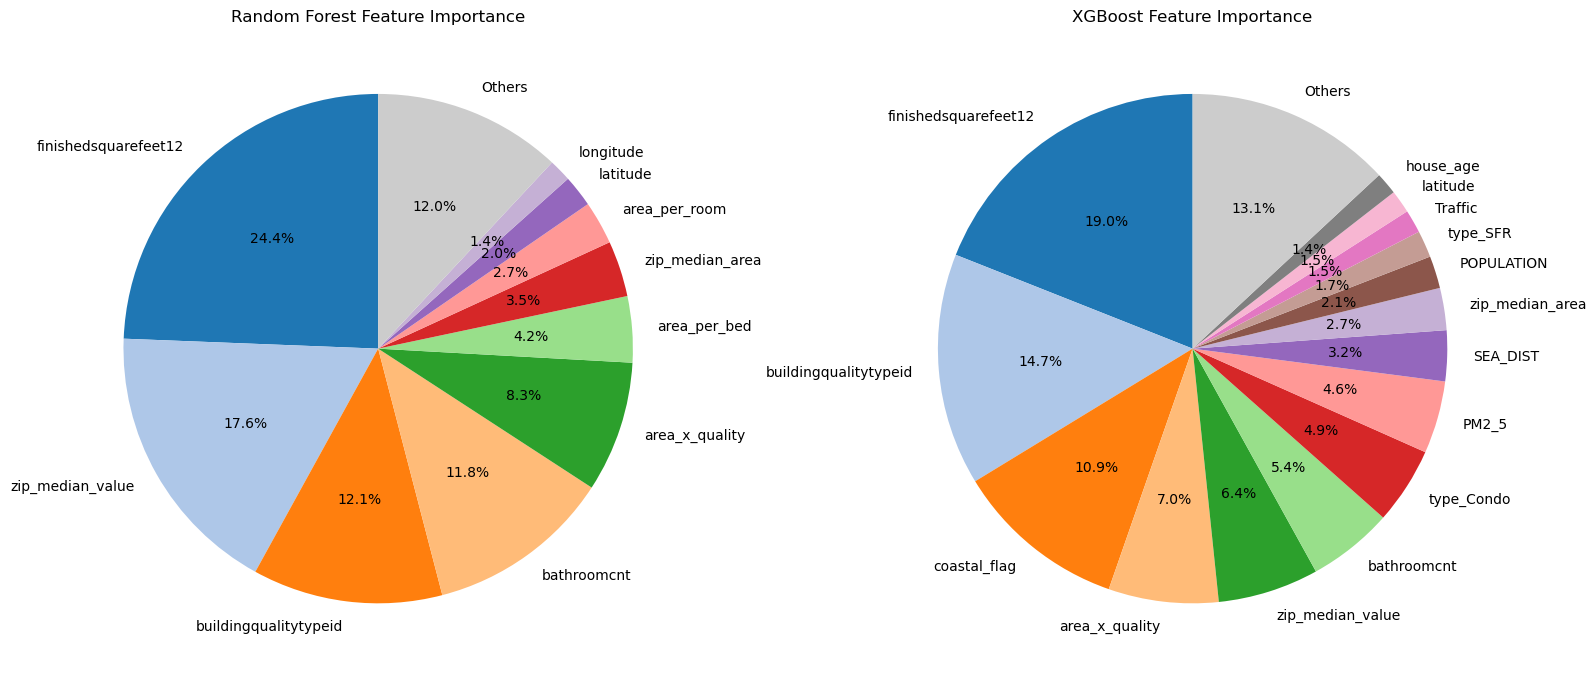

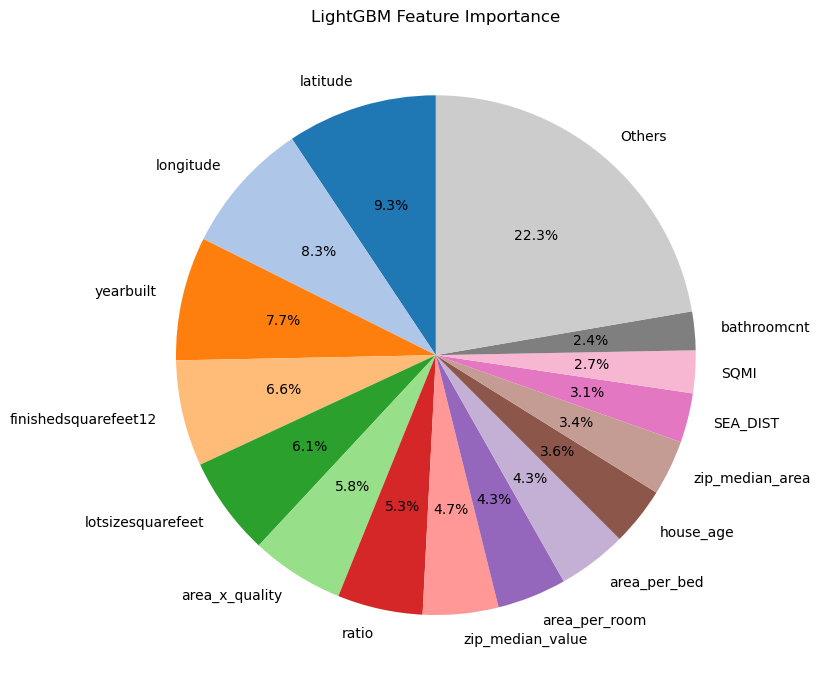

In [14]:
import matplotlib.pyplot as plt

feature_names = X_train.columns

def get_feature_importance_df(model, feature_names, model_name):
    importances = model.feature_importances_
    df_imp = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False).reset_index(drop=True)

    print(f"\n===== {model_name} Feature Importance (sorted) =====")
    print(df_imp)
    csv_name = f"{model_name.replace(' ', '_')}_feature_importance.csv"
    df_imp.to_csv(csv_name, index=False)
    print(f"Saved CSV: {csv_name}")
    return df_imp

rf_importance_df = get_feature_importance_df(rf_reg, feature_names, "Random Forest")
xgb_importance_df = get_feature_importance_df(xgb_reg, feature_names, "XGBoost")
lgbm_importance_df = get_feature_importance_df(lgbm_reg, feature_names, "LightGBM")

def prepare_top_n(df_imp, top_n=10):
    top_df = df_imp.iloc[:top_n].copy()
    if len(df_imp) > top_n:
        others_sum = df_imp.iloc[top_n:]["importance"].sum()
        top_df.loc[len(top_df)] = ["Others", others_sum]
    return top_df

rf_top = prepare_top_n(rf_importance_df, top_n=10)
xgb_top = prepare_top_n(xgb_importance_df, top_n=15)
lgbm_top = prepare_top_n(lgbm_importance_df, top_n=15)

fig1, axes1 = plt.subplots(1, 2, figsize=(16, 7))
models_1 = ["Random Forest", "XGBoost"]
dfs_1 = [rf_top, xgb_top]

for ax, df, title in zip(axes1, dfs_1, models_1):
    default_colors = plt.get_cmap("tab20").colors[:len(df)]
    colors = [("#cccccc" if f == "Others" else c)
              for f, c in zip(df["feature"], default_colors)]

    ax.pie(
        df["importance"],
        labels=df["feature"],
        autopct="%1.1f%%",
        startangle=90,
        colors=colors
    )
    ax.set_title(f"{title} Feature Importance")

plt.tight_layout()
plt.savefig("rf_xgb_feature_importance.png", dpi=600, bbox_inches="tight")
plt.show()

fig2, ax2 = plt.subplots(1, 1, figsize=(8, 7))

df = lgbm_top
default_colors = plt.get_cmap("tab20").colors[:len(df)]
colors = [("#cccccc" if f == "Others" else c)
          for f, c in zip(df["feature"], default_colors)]

ax2.pie(
    df["importance"],
    labels=df["feature"],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors
)
ax2.set_title("LightGBM Feature Importance")

plt.tight_layout()
plt.savefig("lgbm_feature_importance.png", dpi=600, bbox_inches="tight")
plt.show()


In [11]:
#Hybrid (RF + XGB)
hybrid_train_pred = 0.5 * rf_reg.predict(X_train) + 0.5 * xgb_reg.predict(X_train)
hybrid_test_pred  = 0.5 * rf_reg.predict(X_test)  + 0.5 * xgb_reg.predict(X_test)

r2_tr, mae_tr, rmse_tr, mape_tr, mase_tr, rmsle_tr = compute_metrics(y_train, hybrid_train_pred, baseline_mae_train)
r2_te, mae_te, rmse_te, mape_te, mase_te, rmsle_te = compute_metrics(y_test, hybrid_test_pred, baseline_mae_test)

print("\n===== Hybrid (RF + XGB) Train Results =====")
print(f"R2: {r2_tr:.4f}")
print(f"MAE: {mae_tr:.4f}")
print(f"RMSE: {rmse_tr:.4f}")
print(f"MAPE: {mape_tr:.4f}")
print(f"MASE: {mase_tr:.4f}")
print(f"RMSLE: {rmsle_tr:.4f}")

print("\n===== Hybrid (RF + XGB) Test Results =====")
print(f"R2: {r2_te:.4f}")
print(f"MAE: {mae_te:.4f}")
print(f"RMSE: {rmse_te:.4f}")
print(f"MAPE: {mape_te:.4f}")
print(f"MASE: {mase_te:.4f}")
print(f"RMSLE: {rmsle_te:.4f}")


===== Hybrid (RF + XGB) Train Results =====
R2: 0.6347
MAE: 149796.6486
RMSE: 258003.0869
MAPE: 72.3593
MASE: 0.6186
RMSLE: 0.6397

===== Hybrid (RF + XGB) Test Results =====
R2: 0.6168
MAE: 152408.0780
RMSE: 264661.8187
MAPE: 73.0831
MASE: 0.6275
RMSLE: 0.6445


In [12]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    min_samples_leaf=50,
    max_samples=0.5,
    max_features=8,
    n_jobs=-1,
    random_state=42
)

xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.10,
    min_child_weight=250,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_lambda=10,
    reg_alpha=0.5,
    tree_method='hist',
    n_jobs=4,
    random_state=42
)

lgbm_reg = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.02,
    num_leaves=60,
    lambda_l1=2.0,
    lambda_l2=10.0,
    min_child_samples=350,
    subsample=1,
    subsample_freq=1,
    colsample_bytree=0.6,
    metric='rmse',
    n_jobs=-1,
    random_state=42
)

#Do stacking based on RF,XGB and LGBM
base_estimators = [
    ('rf', rf_reg),
    ('xgb', xgb_reg),
    ('lgbm', lgbm_reg),
]

stack_reg = StackingRegressor(
    estimators=base_estimators,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

stack_reg.fit(X_train, y_train)

y_train_pred_stack = stack_reg.predict(X_train)
y_test_pred_stack = stack_reg.predict(X_test)

r2_tr, mae_tr, rmse_tr, mape_tr, mase_tr, rmsle_tr = compute_metrics(y_train, y_train_pred_stack, baseline_mae_train)
r2_te, mae_te, rmse_te, mape_te, mase_te, rmsle_te = compute_metrics(y_test, y_test_pred_stack, baseline_mae_test)

print("Stacked Ensemble Metrics (tuned base models):")
print(f"Train -> R^2: {r2_tr:.4f}, MAE: {mae_tr:.2f}, RMSE: {rmse_tr:.2f}, "
      f"MAPE: {mape_tr:.2f}%, MASE: {mase_tr:.3f}, RMSLE: {rmsle_tr:.4f}")
print(f"Test  -> R^2: {r2_te:.4f}, MAE: {mae_te:.2f}, RMSE: {rmse_te:.2f}, "
      f"MAPE: {mape_te:.2f}%, MASE: {mase_te:.3f}, RMSLE: {rmsle_te:.4f}")


[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
Stacked Ensemble Metrics (tuned base models):
Train -> R^2: 0.6412, MAE: 150202.18, RMSE: 255710.30, MAPE: 72.80%, MASE: 0.620, RMSLE: 0.6430
Test  -> R^2: 0.6223, MAE: 152088.28, RMSE: 262740.45, MAPE: 72.96%, MASE: 0.626, RMSLE: 0.6442


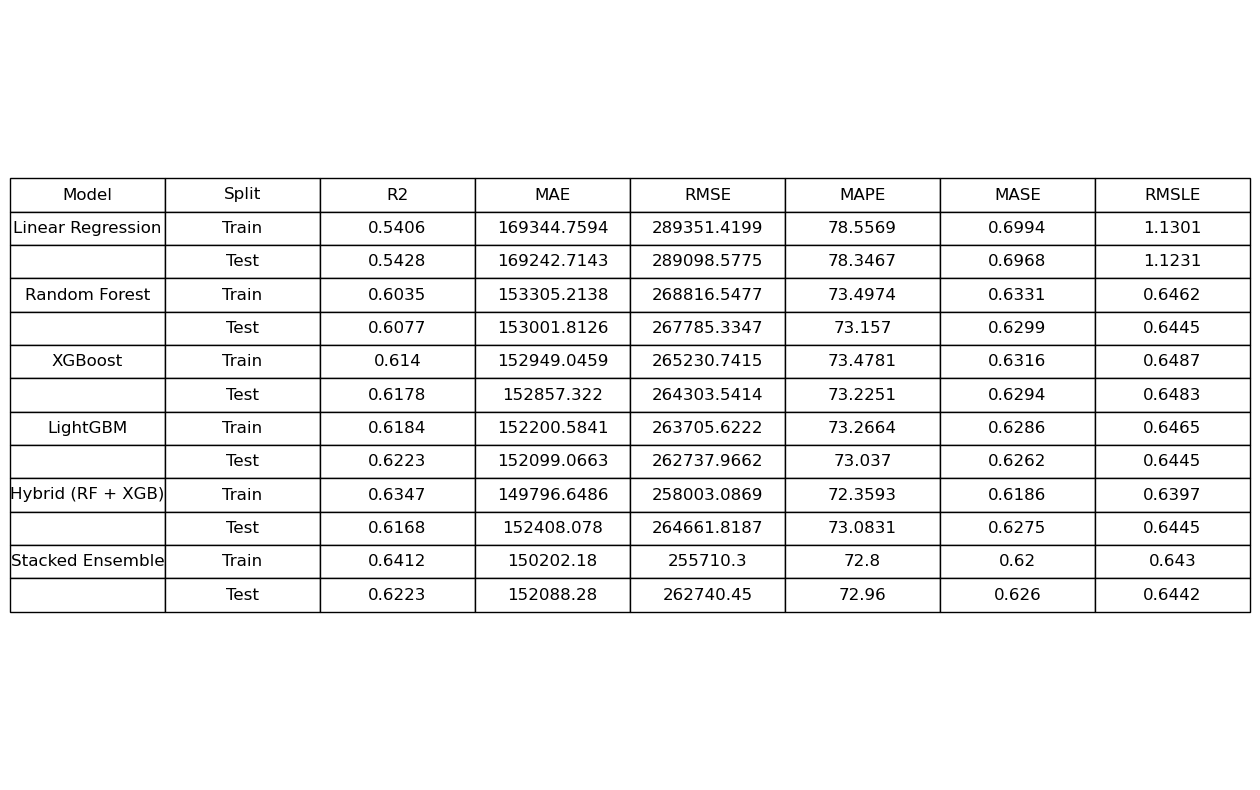

In [21]:
rows = [
    ["Linear Regression", "Train", 0.5406, 169344.7594, 289351.4199, 78.5569, 0.6994, 1.1301],
    ["", "Test", 0.5428, 169242.7143, 289098.5775, 78.3467, 0.6968, 1.1231],

    ["Random Forest", "Train", 0.6035, 153305.2138, 268816.5477, 73.4974, 0.6331, 0.6462],
    ["", "Test", 0.6077, 153001.8126, 267785.3347, 73.1570, 0.6299, 0.6445],

    ["XGBoost", "Train", 0.6140, 152949.0459, 265230.7415, 73.4781, 0.6316, 0.6487],
    ["", "Test", 0.6178, 152857.3220, 264303.5414, 73.2251, 0.6294, 0.6483],

    ["LightGBM", "Train", 0.6184, 152200.5841, 263705.6222, 73.2664, 0.6286, 0.6465],
    ["", "Test", 0.6223, 152099.0663, 262737.9662, 73.0370, 0.6262, 0.6445],

    ["Hybrid (RF + XGB)", "Train", 0.6347, 149796.6486, 258003.0869, 72.3593, 0.6186, 0.6397],
    ["", "Test", 0.6168, 152408.0780, 264661.8187, 73.0831, 0.6275, 0.6445],

    ["Stacked Ensemble", "Train", 0.6412, 150202.18, 255710.30, 72.80, 0.620, 0.6430],
    ["", "Test", 0.6223, 152088.28, 262740.45, 72.96, 0.626, 0.6442],
]

df = pd.DataFrame(rows, columns=["Model", "Split", "R2", "MAE", "RMSE", "MAPE", "MASE", "RMSLE"])

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis("off")

table = ax.table(
    cellText=df.round(4).values,
    colLabels=df.columns,
    loc="center",
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

plt.savefig("model_metrics_table.png", dpi=600, bbox_inches="tight")
plt.show()
